### 实验5 综合实验(大作业)
#### 题目2:疫情微博情绪分类(NLP领域)
+ 任务概述<br>
微博情绪分类任务旨在识别微博中蕴含的情绪，`输入`是一条微博，`输出`是该微博所蕴含的情绪类别。 <br>
在本次任务中，我们将微博按照其蕴含的情绪分为以下六个类别之一:积极、愤怒、悲伤、恐惧、惊奇和 无情绪。
+ 数据集来源<br>
本数据集(疫情微博数据集)内的微博内容是在疫情期间使用相关关键字筛选获得的疫情微博，其内容与新冠疫情相关。<br>
链接: https://pan.baidu.com/s/1OB0p0fuMYFUR6zY8bs7Q3A 密码: 1bbg
+ 数据集标签 <br>
每条微博被标注为以下六个类别之一:neural(无情绪)、happy(积极)、angry(愤怒)、sad(悲伤)、fear(恐惧)、surprise(惊奇)。<br>
+ 数据集规模 <br>
疫情微博训练数据集包括6,606条微博，测试数据集包含5,000条微博。
+ 数据集形式<br>
数据集为􏰄格式，包含三个字段:数据编号，文本，情绪标签􏰊􏰁􏰋。<br>
 示例: {"id": 11, "content": "武汉加油!中国加油!安徽加油!", "label": "happy"}

In [1]:
import re
import jieba
import json
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from gensim import models
from torch.utils import data
from torch import nn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# data_dir = Path('/Users/zhengchubin/PycharmProjects/learn/data/疫情微博情感分类数据集/')
data_dir = Path('/root/zhengchubin/data/疫情微博情感分类数据集/')
train_file = data_dir.joinpath('virus_train.txt')
test_file = data_dir.joinpath('virus_eval_labeled.txt')

virus_train = json.load(train_file.open(mode='r'))
virus_train = pd.DataFrame.from_records(virus_train)

virus_eval_labeled = json.load(test_file.open(mode='r'))
virus_eval_labeled = pd.DataFrame.from_records(virus_eval_labeled)

print(virus_train.shape, virus_train.shape)
virus_train.head()

(8606, 3) (8606, 3)


,id,content,label
0,1,天使,happy
1,2,致敬[心][心]小凡也要做好防护措施哦//@Mr_凡先生:致敬[心]大家出门记得戴口罩,happy
2,3,[中国赞][中国赞][中国赞],happy
3,4,悲壮,sad
4,5,！！！一定会好起来,happy


In [3]:
print(virus_train['label'].value_counts())
print(virus_eval_labeled['label'].value_counts())

happy       4423
neural      1460
angry       1322
sad          649
fear         555
surprise     197
Name: label, dtype: int64
happy       923
neural      476
angry       314
sad         165
fear         75
surprise     47
Name: label, dtype: int64


#### 预处理: 分词、过滤停用词

In [4]:
STOP_WORD_PATTERN = re.compile(
    r"""(//@.*?:|@.*?\s|http://[0-9a-zA-Z._?&/]+|[a-zA-Z]+\.[0-9a-zA-Z._?&/]+|#.*?#|点击链接查看更多|[\s\n？“、！?!，…”【～】。(_)\[\]\->])""")


class MyCorpus():

    def __init__(self, content, based_word=True):
        self.content = content
        self.based_word = based_word

    @classmethod
    def process(self, text: str) -> list:
        """
        分词/过滤停用词
        :param text:
        :return:
        """
        text = STOP_WORD_PATTERN.sub('', text)

        words = jieba.cut(text)
        tokens = []
        for word in words:
            tokens.append(word)
        return tokens

    @classmethod
    def process_char(self, text: str) -> list:
        """
        分词/过滤停用词
        :param text:
        :return:
        """
        text = STOP_WORD_PATTERN.sub('', text)
        tokens = []
        for char in text:
            tokens.append(char)
        return tokens

    def __iter__(self):
        for text in self.content:
            if self.based_word:
                tokens = self.process(text)
            else:
                tokens = self.process_char(text)
            if len(tokens) > 0:
                yield tokens


virus_train['tokens'] = virus_train['content'].apply(lambda x: MyCorpus.process(x))
virus_train['tokens_len'] = virus_train['tokens'].apply(lambda x: len(x))

virus_train['chars'] = virus_train['content'].apply(lambda x: MyCorpus.process_char(x))
virus_train['chars_len'] = virus_train['chars'].apply(lambda x: len(x))

virus_eval_labeled['tokens'] = virus_eval_labeled['content'].apply(lambda x: MyCorpus.process(x))
virus_eval_labeled['tokens_len'] = virus_eval_labeled['tokens'].apply(lambda x: len(x))

virus_eval_labeled['chars'] = virus_eval_labeled['content'].apply(lambda x: MyCorpus.process(x))
virus_eval_labeled['chars_len'] = virus_eval_labeled['chars'].apply(lambda x: len(x))

print(virus_train.describe())
virus_train.head()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.779 seconds.
Prefix dict has been built successfully.


                id   tokens_len    chars_len
count  8606.000000  8606.000000  8606.000000
mean   4303.500000    19.954567    35.156286
std    2484.482542    35.575516    63.224908
min       1.000000     0.000000     0.000000
25%    2152.250000     5.000000     8.000000
50%    4303.500000    11.000000    19.000000
75%    6454.750000    24.000000    42.000000
max    8606.000000  1613.000000  2739.000000


,id,content,label,tokens,tokens_len,chars,chars_len
0,1,天使,happy,[天使],1,"[天, 使]",2
1,2,致敬[心][心]小凡也要做好防护措施哦//@Mr_凡先生:致敬[心]大家出门记得戴口罩,happy,"[致敬, 心心, 小凡, 也, 要, 做好, 防护, 措施, 哦, 致敬, 心, 大家, 出...",16,"[致, 敬, 心, 心, 小, 凡, 也, 要, 做, 好, 防, 护, 措, 施, 哦, ...",27
2,3,[中国赞][中国赞][中国赞],happy,"[中国, 赞, 中国, 赞, 中国, 赞]",6,"[中, 国, 赞, 中, 国, 赞, 中, 国, 赞]",9
3,4,悲壮,sad,[悲壮],1,"[悲, 壮]",2
4,5,！！！一定会好起来,happy,"[一定, 会, 好, 起来]",4,"[一, 定, 会, 好, 起, 来]",6


#### 预处理: 训练词/字向量
https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

In [5]:
def train_w2v(based_word=True):
    """
    训练词向量
    :param based_word:
    :return:
    """
    w2v_dir = Path('/root/zhengchubin/data/models/')
    # w2v_dir = Path('/Users/zhengchubin/PycharmProjects/learn/data/models/')
    if based_word:
        f_name = w2v_dir.joinpath('w2v.word.model').__str__()
    else:
        f_name = w2v_dir.joinpath('w2v.char.model').__str__()

    ## 训练词向量模型
    sentences = MyCorpus(virus_train['content'], based_word=based_word)
    model = models.Word2Vec(sentences=sentences, vector_size=32,
                            min_count=1, sg=1, epochs=20, workers=4)

    for index, word in enumerate(model.wv.index_to_key):
        if index == 10:
            break
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

    # 写词向量模型
    model.save(f_name)


train_w2v(based_word=True)
train_w2v(based_word=False)

word #0/17400 is 的
word #1/17400 is 了
word #2/17400 is 都
word #3/17400 is 我
word #4/17400 is 加油
word #5/17400 is 在
word #6/17400 is 武汉
word #7/17400 is 是
word #8/17400 is 我们
word #9/17400 is 大家
word #0/3412 is 的
word #1/3412 is 一
word #2/3412 is 人
word #3/3412 is 了
word #4/3412 is 我
word #5/3412 is 不
word #6/3412 is 是
word #7/3412 is 们
word #8/3412 is 有
word #9/3412 is 心


#### 预处理: 构建嵌入层

In [10]:
def creat_embedding(model: models.Word2Vec):
    """
    创建嵌入矩阵
    :return:
    """
    word2index = {'<pad>': 0}
    # 训练语料的词表大小
    vocab_size = len(model.wv.key_to_index)

    # 第1个向量为0向量，主要用来补齐
    index2vector = torch.zeros(size=(vocab_size + 1, model.wv.vector_size))

    for key, index in model.wv.key_to_index.items():
        word2index[key] = index + 1
        index2vector[index + 1, :] = torch.from_numpy(model.wv.get_vector(key).copy())

    return word2index, index2vector


w2v_dir = Path('/root/zhengchubin/data/models/')
# w2v_dir = Path('/Users/zhengchubin/PycharmProjects/learn/data/models/')

# 词向量
f_name = w2v_dir.joinpath('w2v.word.model').__str__()
w2v_model = models.Word2Vec.load(f_name)
word2index, word2vector = creat_embedding(w2v_model)
print('基于词', len(word2index), word2vector.size())

# 字向量
f_name = w2v_dir.joinpath('w2v.char.model').__str__()
w2v_model = models.Word2Vec.load(f_name)
char2index, char2vector = creat_embedding(w2v_model)
print('基于字', len(char2index), char2vector.size())

# 标签
labels = list(virus_train['label'].unique())
label2index = {label: i for i, label in enumerate(labels)}
index2label = {i: label for label, i in label2index.items()}
label2index

基于词 17401 torch.Size([17401, 32])
基于字 3413 torch.Size([3413, 32])


{'happy': 0, 'sad': 1, 'neural': 2, 'fear': 3, 'angry': 4, 'surprise': 5}

#### 预处理: 构建训练语料

In [28]:
def gen_corpus(dataset: pd.DataFrame, word2index: dict,
               label2index: dict, max_seq_len: int, word_based=True) -> torch.utils.data.TensorDataset:
    x, y = [], []
    for num, _row in enumerate(dataset.itertuples(), start=1):
        if word_based:
            tokens = getattr(_row, 'tokens')
        else:
            tokens = getattr(_row, 'chars')

        label = getattr(_row, 'label')
        indices = []
        for token in tokens:
            if len(indices) >= max_seq_len:
                break
            indices.append(word2index.get(token, 0))

        # 补齐
        if len(indices) < max_seq_len:
            indices += (max_seq_len -len(indices)) * [0]

        x.append(indices)
        y.append(label2index.get(label))
        
        if num <= 10:
            print('tokens: ', tokens)
            print('indices:', indices)
            print()

    x, y = torch.LongTensor(x), torch.LongTensor(y)
    print(f'x.shape={x.shape}, y.shape={y.shape}')
    return torch.utils.data.TensorDataset(x, y)

# 基于词
train_set_word = gen_corpus(virus_train, word2index, label2index, max_seq_len=25)
test_set_word = gen_corpus(virus_eval_labeled, word2index, label2index, max_seq_len=25)

# 基于字
train_set_char = gen_corpus(virus_train, char2index, label2index,
                            max_seq_len=45, word_based=False)
test_set_char = gen_corpus(virus_eval_labeled, char2index, label2index,
                           max_seq_len=45, word_based=False)

tokens:  ['天使']
indices: [2593, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

tokens:  ['致敬', '心心', '小凡', '也', '要', '做好', '防护', '措施', '哦', '致敬', '心', '大家', '出门', '记得', '戴', '口罩']
indices: [22, 683, 10886, 17, 11, 77, 58, 137, 296, 22, 18, 10, 98, 262, 50, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0]

tokens:  ['中国', '赞', '中国', '赞', '中国', '赞']
indices: [76, 181, 76, 181, 76, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

tokens:  ['悲壮']
indices: [10890, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

tokens:  ['一定', '会', '好', '起来']
indices: [40, 51, 15, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

tokens:  ['我', '看到', '有人', '说', '婆婆', '你', '这', '两天', '发', '那么', '多', '新型', '冠状病毒', '的', '消息', '我们', '很', '慌', '啊', '不要', '慌', '我', '之所以', '发', '这么', '多', '关于', '这件', '事', '的', '信息', '就是', '因为', '在我看来', '所有', '的', '恐慌', '都', '来自', '于', '未知', '只有', '及时', '有效', '的', '公开', '最新', '信息', '让', '公众', '全面', '及时', '的', '了解', '

#### 模型训练与评估

In [20]:
def evaluate_loss_acc(test_set: torch.utils.data.Dataset,
                      net: nn.Module, loss_fn, batch_size=256):
    """
    返回测试集的loss
    :return:
    """
    test_set_iter = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
    test_l_sum, acc_sum, batch_no, n = 0.0, 0.0, 0, 0

    # 评估模式
    net.eval()

    for X, y_true in test_set_iter:

        y_true = y_true.long()
        y_true: torch.Tensor = y_true.view(-1)

        # 损失值
        y_hat: torch.Tensor = net(X)
        batch_loss = loss_fn(y_hat, y_true).sum().item()

        # 正确率
        y_hat = y_hat.argmax(dim=1)
        batch_acc = (y_hat == y_true).float().sum().item()

        batch_no += 1
        n += y_true.shape[0]
        test_l_sum += batch_loss
        acc_sum += batch_acc

    # 改回训练模式
    net.train(mode=True)

    return test_l_sum/batch_no, acc_sum/n


class MyClassificationModel(nn.Module):

    def __init__(self, vector_matrix, hidden_size, output_size,
                 drop_out_rate=0.3, bidirectional=False):
        super(MyClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = 1
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding.from_pretrained(vector_matrix)
        self.lstm = nn.LSTM(
            input_size=self.embedding.embedding_dim,
            batch_first=True,
            hidden_size=hidden_size,
            bidirectional=self.bidirectional,
            num_layers=self.num_layers
        )
        if bidirectional:
            hidden_size = 2 * self.num_layers * hidden_size
        else:
            hidden_size = self.num_layers * hidden_size

        # 激活函数
        # self.relu = nn.LeakyReLU()
        # self.tanh = nn.Tanh()

        self.drop_out = nn.Dropout(p=drop_out_rate)

        # self.linear_1 = nn.Linear(hidden_size, hidden_size//2)
        # self.softmax = nn.Linear(hidden_size//2, output_size)
        self.softmax = nn.Linear(hidden_size, output_size)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor):

        # 转为词向量 [128, 30, 32]
        output = self.embedding(x)

        # LSTM
        if self.bidirectional:
            # outputs: [128, 30, 2 * 32],
            # h_n:     [2, 128, 32]
            outputs,(h_n, c_n) = self.lstm(output, None)  # (h, c)

            output_fw = h_n[-2, :, :]  # 正向最后一次的输出
            output_bw = h_n[-1, :, :]  # 反向最后一次的输出
            output = torch.cat([output_fw, output_bw], dim=-1)  # [128, 30, 64]

        else:
            # [128, 30, 32]
            output, _ = self.lstm(output, None)  # h

            # 选取最后一个时刻的输出 [128, 32]
            output = output[:, -1, :]

        output = self.drop_out(output)

        # 线性层
        # output = self.linear_1(output)
        # output = self.relu(output)
        # output = self.drop_out(output)

        output = self.softmax(output)
        return output

#####  单向 LSTM: 基于词

MyClassificationModel(
  (embedding): Embedding(17401, 32)
  (lstm): LSTM(32, 32, batch_first=True)
  (drop_out): Dropout(p=0.3, inplace=False)
  (softmax): Linear(in_features=32, out_features=6, bias=True)
)
epoch 1, train_loss 1.522800, test_loss 1.449323, train_acc 0.480130, test_acc 0.461500
epoch 2, train_loss 1.384449, test_loss 1.405649, train_acc 0.513944, test_acc 0.461500
epoch 3, train_loss 1.360022, test_loss 1.390977, train_acc 0.516035, test_acc 0.462500
epoch 4, train_loss 1.322239, test_loss 1.321197, train_acc 0.532535, test_acc 0.495500
epoch 5, train_loss 1.243906, test_loss 1.260997, train_acc 0.536370, test_acc 0.517500
epoch 6, train_loss 1.254751, test_loss 1.380617, train_acc 0.533465, test_acc 0.462500
epoch 7, train_loss 1.187593, test_loss 1.339564, train_acc 0.545550, test_acc 0.467000
epoch 8, train_loss 1.113576, test_loss 1.400975, train_acc 0.571810, test_acc 0.333000
epoch 9, train_loss 1.105945, test_loss 1.325398, train_acc 0.569254, test_acc 0.561500

epoch 91, train_loss 0.745823, test_loss 0.952777, train_acc 0.736463, test_acc 0.653500
epoch 92, train_loss 0.749016, test_loss 0.977781, train_acc 0.734488, test_acc 0.653500
epoch 93, train_loss 0.756188, test_loss 1.061925, train_acc 0.736463, test_acc 0.614500
epoch 94, train_loss 0.749568, test_loss 0.952584, train_acc 0.737625, test_acc 0.656500
epoch 95, train_loss 0.750035, test_loss 0.987082, train_acc 0.732861, test_acc 0.627000
epoch 96, train_loss 0.742365, test_loss 1.020019, train_acc 0.741692, test_acc 0.612000
epoch 97, train_loss 0.740024, test_loss 0.996405, train_acc 0.736463, test_acc 0.638500
epoch 98, train_loss 0.741393, test_loss 1.094065, train_acc 0.737974, test_acc 0.656500
epoch 99, train_loss 0.745964, test_loss 1.099377, train_acc 0.741924, test_acc 0.597500
epoch 100, train_loss 0.748270, test_loss 0.917483, train_acc 0.739135, test_acc 0.668500


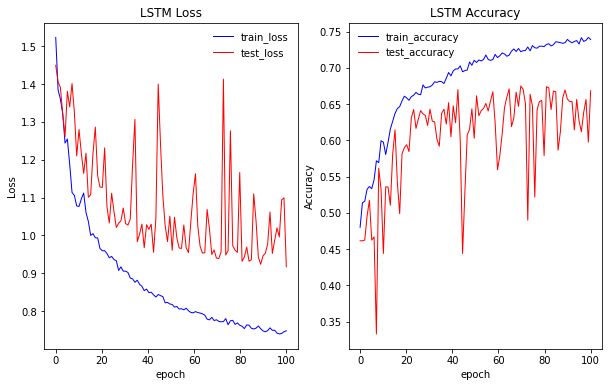

In [21]:
# 参数配置
batch_size = 128
hidden_size = 32
output_size = len(label2index)
num_epochs = 100
drop_out_rate = 0.3
lr = 0.1

net = MyClassificationModel(vector_matrix=word2vector,hidden_size=hidden_size,
                            output_size=output_size, drop_out_rate=drop_out_rate,
                            bidirectional=False)
print(net)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(num_epochs):

    train_set_iter = torch.utils.data.DataLoader(train_set_word, batch_size=batch_size, shuffle=True)

    # 一批次的训练数据
    train_l_sum, train_acc_sum, num_batch, n = 0.0, 0.0, 0, 0
    batch_no = 1
    for X, y_true in train_set_iter:

        y_true = y_true.long()
        y_true: torch.Tensor = y_true.view(-1)

        # 模型预测值
        y_hat: torch.Tensor = net(X)
        batch_loss = loss(y_hat, y_true).sum()

        # 反向传播
        optimizer.zero_grad() #清空梯度
        batch_loss.backward()
        optimizer.step()

        y_hat = y_hat.argmax(dim=1)
        batch_acc = (y_hat == y_true).float().sum()

        train_acc_sum += batch_acc.item()
        train_l_sum += batch_loss.item()

        num_batch += 1
        n += y_true.shape[0]

    train_l = train_l_sum / num_batch
    train_acc = train_acc_sum / n
    test_l, test_acc = evaluate_loss_acc(test_set_word, net, loss, batch_size=batch_size)

    train_loss.append(float(train_l))
    test_loss.append(float(test_l))
    train_accuracy.append(float(train_acc))
    test_accuracy.append(float(test_acc))

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_l, test_l, train_acc_sum/n, test_acc))

x = np.linspace(0, num_epochs, num_epochs)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)

ax1.plot(x, train_loss, 'b-', label="train_loss", lw=1)
ax1.plot(x, test_loss, 'r-', label="test_loss", lw=1)
ax1.set_title('LSTM Loss')
ax1.legend(loc='best', frameon=False)
ax1.set_xlabel("epoch")
ax1.set_ylabel("Loss")

ax2.plot(x, train_accuracy, 'b-', label="train_accuracy", lw=1)
ax2.plot(x, test_accuracy, 'r-', label="test_accuracy", lw=1)
ax2.set_title('LSTM Accuracy')
ax2.legend(loc='best', frameon=False)
ax2.set_xlabel("epoch")
ax2.set_ylabel("Accuracy")

plt.show()

#####  双向 LSTM: 基于词

MyClassificationModel(
  (embedding): Embedding(17401, 32)
  (lstm): LSTM(32, 32, batch_first=True, bidirectional=True)
  (drop_out): Dropout(p=0.3, inplace=False)
  (softmax): Linear(in_features=64, out_features=6, bias=True)
)
epoch 1, train_loss 1.442231, test_loss 1.393969, train_acc 0.488264, test_acc 0.461500
epoch 2, train_loss 1.244501, test_loss 1.268590, train_acc 0.520683, test_acc 0.486000
epoch 3, train_loss 1.100054, test_loss 1.185704, train_acc 0.579247, test_acc 0.573000
epoch 4, train_loss 1.057734, test_loss 1.171376, train_acc 0.611782, test_acc 0.582500
epoch 5, train_loss 1.036258, test_loss 1.140473, train_acc 0.622240, test_acc 0.591500
epoch 6, train_loss 1.012609, test_loss 1.108924, train_acc 0.633744, test_acc 0.600000
epoch 7, train_loss 0.988684, test_loss 1.080046, train_acc 0.646874, test_acc 0.609500
epoch 8, train_loss 0.973372, test_loss 1.052445, train_acc 0.655124, test_acc 0.619500
epoch 9, train_loss 0.951550, test_loss 1.066810, train_acc 0.65837

epoch 91, train_loss 0.706874, test_loss 0.951175, train_acc 0.744829, test_acc 0.659000
epoch 92, train_loss 0.712696, test_loss 0.966249, train_acc 0.744597, test_acc 0.654500
epoch 93, train_loss 0.706119, test_loss 0.922558, train_acc 0.753312, test_acc 0.672500
epoch 94, train_loss 0.707571, test_loss 0.930448, train_acc 0.745643, test_acc 0.667500
epoch 95, train_loss 0.701830, test_loss 0.934269, train_acc 0.747850, test_acc 0.673000
epoch 96, train_loss 0.702864, test_loss 1.011200, train_acc 0.748896, test_acc 0.619500
epoch 97, train_loss 0.703762, test_loss 0.938180, train_acc 0.748780, test_acc 0.660000
epoch 98, train_loss 0.704716, test_loss 1.105192, train_acc 0.746572, test_acc 0.592000
epoch 99, train_loss 0.704673, test_loss 0.966462, train_acc 0.747502, test_acc 0.653500
epoch 100, train_loss 0.701363, test_loss 0.942088, train_acc 0.749477, test_acc 0.660500


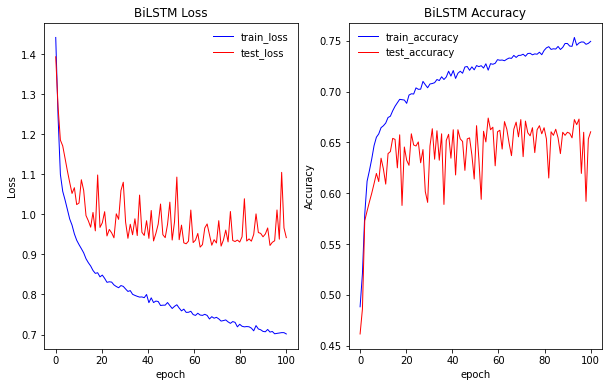

In [22]:
# 参数配置
batch_size = 128
hidden_size = 32
output_size = len(label2index)
num_epochs = 100
drop_out_rate = 0.3
lr = 0.1

net = MyClassificationModel(vector_matrix=word2vector,hidden_size=hidden_size,
                            output_size=output_size, drop_out_rate=drop_out_rate,
                            bidirectional=True)
print(net)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(num_epochs):

    train_set_iter = torch.utils.data.DataLoader(train_set_word, batch_size=batch_size, shuffle=True)

    # 一批次的训练数据
    train_l_sum, train_acc_sum, num_batch, n = 0.0, 0.0, 0, 0
    batch_no = 1
    for X, y_true in train_set_iter:

        y_true = y_true.long()
        y_true: torch.Tensor = y_true.view(-1)

        # 模型预测值
        y_hat: torch.Tensor = net(X)
        batch_loss = loss(y_hat, y_true).sum()

        # 反向传播
        optimizer.zero_grad() #清空梯度
        batch_loss.backward()
        optimizer.step()

        y_hat = y_hat.argmax(dim=1)
        batch_acc = (y_hat == y_true).float().sum()

        train_acc_sum += batch_acc.item()
        train_l_sum += batch_loss.item()

        num_batch += 1
        n += y_true.shape[0]

    train_l = train_l_sum / num_batch
    train_acc = train_acc_sum / n
    test_l, test_acc = evaluate_loss_acc(test_set_word, net, loss, batch_size=batch_size)

    train_loss.append(float(train_l))
    test_loss.append(float(test_l))
    train_accuracy.append(float(train_acc))
    test_accuracy.append(float(test_acc))

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_l, test_l, train_acc_sum/n, test_acc))

# 保存模型
torch.save(net, '/root/zhengchubin/data/models/dl_lab5_bilstm.pth')

    
x = np.linspace(0, num_epochs, num_epochs)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)

ax1.plot(x, train_loss, 'b-', label="train_loss", lw=1)
ax1.plot(x, test_loss, 'r-', label="test_loss", lw=1)
ax1.set_title('BiLSTM Loss')
ax1.legend(loc='best', frameon=False)
ax1.set_xlabel("epoch")
ax1.set_ylabel("Loss")

ax2.plot(x, train_accuracy, 'b-', label="train_accuracy", lw=1)
ax2.plot(x, test_accuracy, 'r-', label="test_accuracy", lw=1)
ax2.set_title('BiLSTM Accuracy')
ax2.legend(loc='best', frameon=False)
ax2.set_xlabel("epoch")
ax2.set_ylabel("Accuracy")

plt.show()

In [24]:
test_set_iter = torch.utils.data.DataLoader(test_set_word, batch_size=batch_size, shuffle=True)

y_trues = []
y_hats = []

for X, y_true in test_set_iter:
    y_hat: torch.Tensor = net(X)
    y_hat = y_hat.argmax(dim=1)
    y_trues.extend(y_true.numpy())
    y_hats.extend(y_hat.numpy())

y_trues = np.array(y_trues)
y_hats = np.array(y_hats)

print(classification_report(y_trues, y_hats, target_names=labels))
print(accuracy_score(y_trues, y_hats))


              precision    recall  f1-score   support

       happy       0.80      0.81      0.80       923
         sad       0.44      0.20      0.28       165
      neural       0.62      0.57      0.59       476
        fear       0.23      0.33      0.27        75
       angry       0.52      0.72      0.60       314
    surprise       0.67      0.04      0.08        47

    accuracy                           0.65      2000
   macro avg       0.55      0.45      0.44      2000
weighted avg       0.66      0.65      0.64      2000

0.653


#####  单向 LSTM: 基于字

MyClassificationModel(
  (embedding): Embedding(3413, 32)
  (lstm): LSTM(32, 32, batch_first=True)
  (drop_out): Dropout(p=0.3, inplace=False)
  (softmax): Linear(in_features=32, out_features=6, bias=True)
)
epoch 1, train_loss 1.504800, test_loss 1.456428, train_acc 0.485940, test_acc 0.461500
epoch 2, train_loss 1.391917, test_loss 1.437362, train_acc 0.513944, test_acc 0.461500
epoch 3, train_loss 1.381668, test_loss 1.431697, train_acc 0.513944, test_acc 0.461500
epoch 4, train_loss 1.368352, test_loss 1.432251, train_acc 0.515222, test_acc 0.461500
epoch 5, train_loss 1.366884, test_loss 1.439760, train_acc 0.518127, test_acc 0.461500
epoch 6, train_loss 1.362923, test_loss 1.431008, train_acc 0.520916, test_acc 0.461500
epoch 7, train_loss 1.358003, test_loss 1.442679, train_acc 0.527423, test_acc 0.462000
epoch 8, train_loss 1.352504, test_loss 1.433589, train_acc 0.528701, test_acc 0.462000
epoch 9, train_loss 1.351060, test_loss 1.430139, train_acc 0.529979, test_acc 0.462500


epoch 91, train_loss 1.374219, test_loss 1.436808, train_acc 0.514292, test_acc 0.461500
epoch 92, train_loss 1.366334, test_loss 1.420613, train_acc 0.518824, test_acc 0.461500
epoch 93, train_loss 1.358539, test_loss 1.414712, train_acc 0.524518, test_acc 0.462500
epoch 94, train_loss 1.356744, test_loss 1.448019, train_acc 0.522775, test_acc 0.461500
epoch 95, train_loss 1.315544, test_loss 1.532407, train_acc 0.524053, test_acc 0.158500
epoch 96, train_loss 1.324407, test_loss 1.421888, train_acc 0.519986, test_acc 0.462000
epoch 97, train_loss 1.355045, test_loss 1.424412, train_acc 0.526493, test_acc 0.463000
epoch 98, train_loss 1.348670, test_loss 1.451575, train_acc 0.524750, test_acc 0.461500
epoch 99, train_loss 1.371479, test_loss 1.435858, train_acc 0.518824, test_acc 0.462000
epoch 100, train_loss 1.366932, test_loss 1.445053, train_acc 0.520102, test_acc 0.461500


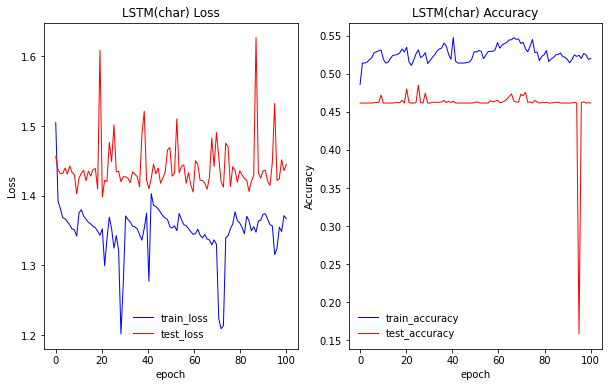

In [15]:
# 参数配置
batch_size = 128
hidden_size = 32
output_size = len(label2index)
num_epochs = 100
drop_out_rate = 0.3
lr = 0.1

net = MyClassificationModel(vector_matrix=char2vector,hidden_size=hidden_size,
                            output_size=output_size, drop_out_rate=drop_out_rate,
                            bidirectional=False)

print(net)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(num_epochs):

    train_set_iter = torch.utils.data.DataLoader(train_set_char, batch_size=batch_size, shuffle=True)

    # 一批次的训练数据
    train_l_sum, train_acc_sum, num_batch, n = 0.0, 0.0, 0, 0
    batch_no = 1
    for X, y_true in train_set_iter:

        y_true = y_true.long()
        y_true: torch.Tensor = y_true.view(-1)

        # 模型预测值
        y_hat: torch.Tensor = net(X)
        batch_loss = loss(y_hat, y_true).sum()

        # 反向传播
        optimizer.zero_grad() #清空梯度
        batch_loss.backward()
        optimizer.step()

        y_hat = y_hat.argmax(dim=1)
        batch_acc = (y_hat == y_true).float().sum()

        train_acc_sum += batch_acc.item()
        train_l_sum += batch_loss.item()

        num_batch += 1
        n += y_true.shape[0]

    train_l = train_l_sum / num_batch
    train_acc = train_acc_sum / n
    test_l, test_acc = evaluate_loss_acc(test_set_char, net, loss, batch_size=batch_size)

    train_loss.append(float(train_l))
    test_loss.append(float(test_l))
    train_accuracy.append(float(train_acc))
    test_accuracy.append(float(test_acc))

    print('epoch %d, train_loss %f, test_loss %f, train_acc %f, test_acc %f'
          % (epoch+1, train_l, test_l, train_acc_sum/n, test_acc))

x = np.linspace(0, num_epochs, num_epochs)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)

ax1.plot(x, train_loss, 'b-', label="train_loss", lw=1)
ax1.plot(x, test_loss, 'r-', label="test_loss", lw=1)
ax1.set_title('LSTM(char) Loss')
ax1.legend(loc='best', frameon=False)
ax1.set_xlabel("epoch")
ax1.set_ylabel("Loss")

ax2.plot(x, train_accuracy, 'b-', label="train_accuracy", lw=1)
ax2.plot(x, test_accuracy, 'r-', label="test_accuracy", lw=1)
ax2.set_title('LSTM(char) Accuracy')
ax2.legend(loc='best', frameon=False)
ax2.set_xlabel("epoch")
ax2.set_ylabel("Accuracy")

plt.show()
